In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Directories
DATA_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\new updates"
TRAIN_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\train_data2"
TEST_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\test_data2"
IMG_SIZE = (224, 224)  # DenseNet requirement
BATCH_SIZE = 16
EPOCHS = 15
MAX_IMAGES_PER_CLASS = 10000

# Dataset Preparation
def prepare_dataset(data_dir, train_dir, test_dir, max_images_per_class, train_split=0.8):
    for dir_path in [train_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split, random_state=42)

            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

prepare_dataset(DATA_DIR, TRAIN_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  # Advanced augmentation
    channel_shift_range=50.0       # Advanced augmentation
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 11895 images belonging to 3 classes.
Found 2976 images belonging to 3 classes.


In [3]:

# Model Definition
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "densenet_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
csv_logger = CSVLogger(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", 'densenet_training_log.csv'))
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler, early_stopping]
)

# Save the Final Model
model.save(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "densenet_final_model.keras"))

c:\Users\farah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.5476 - loss: 8.8488 - val_accuracy: 0.6757 - val_loss: 5.0115 - learning_rate: 1.0000e-04
Epoch 2/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - accuracy: 0.6593 - loss: 4.5665 - val_accuracy: 0.6949 - val_loss: 3.3558 - learning_rate: 1.0000e-04
Epoch 3/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 768s 1s/step - accuracy: 0.6906 - loss: 3.1038 - val_accuracy: 0.7137 - val_loss: 2.3529 - learning_rate: 1.0000e-04
Epoch 4/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 767s 1s/step - accuracy: 0.7053 - loss: 2.2017 - val_accuracy: 0.7124 - val_loss: 1.7207 - learning_rate: 1.0000e-04
Epoch 5/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.7016 - loss: 1.6368 - val_accuracy: 0.7046 - val_loss: 1.3493 - learning_rate: 1.0000e-04
Epoch 6/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.7158 - loss: 1.2752 - val_accuracy: 0.7224 - val_loss: 1.0975 - learning_rate: 1.0000e-04
Epoch 7/15
744/744 ━━━━━━━━━━━━━━━━━━━━ 764s 1s/step - acc

186/186 ━━━━━━━━━━━━━━━━━━━━ 138s 744ms/step - accuracy: 0.8362 - loss: 0.4726
DenseNet Test Accuracy: 0.75
186/186 ━━━━━━━━━━━━━━━━━━━━ 141s 744ms/step


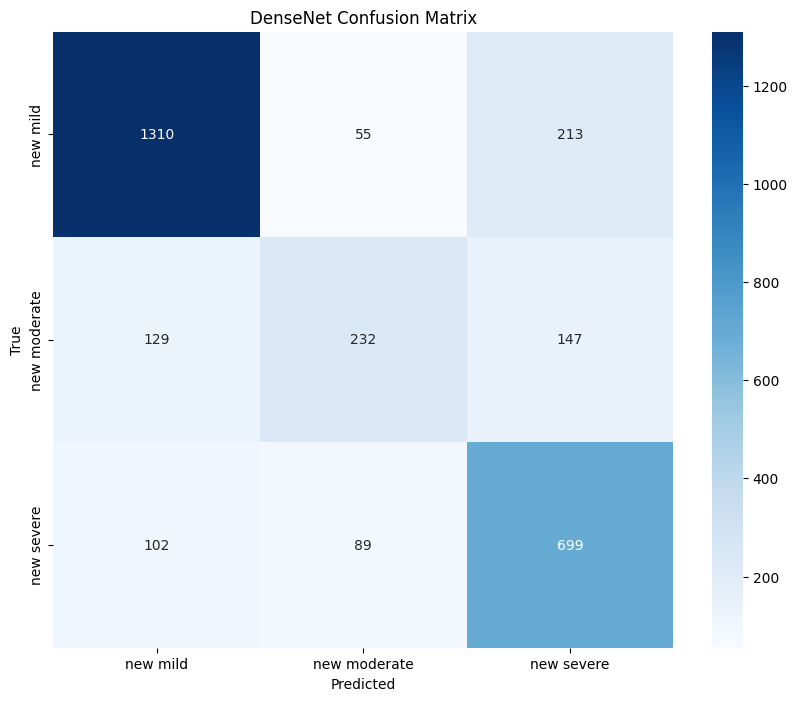

              precision    recall  f1-score   support

    new mild       0.85      0.83      0.84      1578
new moderate       0.62      0.46      0.52       508
  new severe       0.66      0.79      0.72       890

    accuracy                           0.75      2976
   macro avg       0.71      0.69      0.69      2976
weighted avg       0.75      0.75      0.75      2976



In [4]:
# Evaluate the Model
test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"DenseNet Test Accuracy: {test_accuracy:.2f}")

# Predictions and Metrics
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("DenseNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))